这是一个使用软决策树（Soft Decision Tree, SDT）在MNIST手写数字数据集上进行分类并可视化的示例代码。代码展示了如何加载数据集、初始化模型、训练和保存模型以及可视化决策过程。

原论文（"Distilling a Neural Network Into a Soft Decision Tree"）：https://arxiv.org/abs/1711.09784

# 1 载入MNIST手写数字数据集

In [ ]:
import torch
from torchvision import datasets, transforms
import torchvision
import matplotlib.pyplot as plt
import numpy as np

tfm = transforms.ToTensor()  # 自动把 0-255 转成 [0,1] 的 float tensor
trainset = datasets.MNIST(root="~/.data", train=True,  download=True, transform=tfm)
testset  = datasets.MNIST(root="~/.data", train=False, download=True, transform=tfm)

trainloader = torch.utils.data.DataLoader(trainset, batch_size=128, shuffle=True)
testloader  = torch.utils.data.DataLoader(testset,  batch_size=256)

images.shape: torch.Size([128, 1, 28, 28])


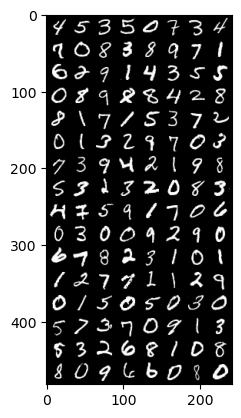

In [ ]:
# 查看并可视化

def imshow(img):
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

images, labels = next(iter(trainloader)) # 取一个 batch 的数据
print(f"images.shape: {images.shape}")

imshow(torchvision.utils.make_grid(images))

# 2 加载 Soft Decision Tree (SDT) 模块

SDT重要参数说明：
- `depth`: 树的深度
- `lamda`: 正则化参数
- `inv_temp`: 逆温度参数，控制决策的硬度。参考知识蒸馏论文中的温度参数，默认值为1.0，即不进行温度调整。
- `hard_leaf_inference`: 是否在推理时使用硬叶节点
  - 当设置为True时，模型在推理时会选择概率最高路径的叶节点作为输出，这使得决策过程更加明确和可解释。
  - 当设置为False时，模型在推理时会考虑所有叶节点的概率分布。
  - 原论文建议如果需要更明确的决策路径（即更高的可解释性），需要设置为**True**。但可能会牺牲一些准确率。
  - 详细解释请参考原论文处："This model can be used to give a predictive distribution over classes in two
                        different ways, namely by using the distribution from the leaf with the greatest
                        path probability or averaging the distributions over all the leaves, weighted by
                        their respective path probabilities. ... "
- `use_penalty_ema`: 是否使用EMA（Exponential Moving Average）平滑来调整正则化
- `penalty_ema_beta`: EMA平滑的衰减系数
  - 这两个参数的意思：给每个内部节点加一个“左右分支要均衡”的正则项，防止节点把几乎所有样本都送到同一侧而导致梯度消失与早期饱和。
  - 原论文指出: "... we can maintain an exponentially decaying running
        average of the actual probabilities with a time window that is
        exponentially proportional to the depth of the node."
  - 可开启 `use_penalty_ema` 以获得更平滑的正则化效果。
- `use_cuda`: 是否使用GPU。经测试，CPU训练速度较快。

In [5]:
# 加载SDT pytorch实现
from SDT_pt import SDT

# 经测试，CPU训练速度较快
# device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device = torch.device("cpu")

use_cuda = (device.type == 'cuda')
input_dim, output_dim = 28*28, 10
# 开启 use_penalty_ema 以获得相近的平衡正则（EMA 平滑 α），参见论文和 SDT_pt.py 实现细节
tree = SDT(input_dim, output_dim, depth=5, lamda=1e-3, use_cuda=use_cuda, inv_temp=1.0,
           hard_leaf_inference=True, use_penalty_ema=True, penalty_ema_beta=0.95).to(device)

optimizer = torch.optim.Adam(tree.parameters(), lr=1e-3, weight_decay=5e-4)
criterion = torch.nn.CrossEntropyLoss()
print(f"Device: {device}, CUDA available: {torch.cuda.is_available()} | use_cuda flag: {use_cuda}")

Device: cpu, CUDA available: True | use_cuda flag: False


In [ ]:
# 完整训练/评估例程（可调 epoch）
from time import time

def train_and_eval(epochs=2, log_interval=100):
    best_acc = 0.0

    # 记录loss和accuracy
    train_losses = []
    test_accuracies = []

    for epoch in range(1, epochs+1):
        # Train
        tree.train()
        t0 = time()
        for batch_idx, (data, target) in enumerate(trainloader):
            data, target = data.to(device), target.to(device)
            logits, penalty = tree.forward(data, is_training_data=True)
            loss = criterion(logits, target) + penalty
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            if batch_idx % log_interval == 0:
                with torch.no_grad():
                    pred = logits.argmax(dim=1)
                    correct = (pred == target).sum().item()
                print(f"Epoch {epoch:02d} | Batch {batch_idx:04d} | Loss {loss.item():.5f} | Correct {correct}/{data.size(0)}")
                train_losses.append((f"Epoch {epoch:02d}", loss.item()))
        dt = time() - t0
        # Eval
        tree.eval()
        correct = 0
        total = 0
        with torch.no_grad():
            for data, target in testloader:
                data, target = data.to(device), target.to(device)
                logits = tree.forward(data)  # logits 即可 argmax
                pred = logits.argmax(dim=1)
                correct += (pred == target).sum().item()
                total += target.size(0)
        acc = 100.0 * correct / total
        best_acc = max(best_acc, acc)
        print(f"Epoch {epoch:02d} | Test Acc: {acc:.3f}% | Best: {best_acc:.3f}% | epoch_time: {dt:.1f}s")
        test_accuracies.append((f"Epoch {epoch:02d}", acc))
    return best_acc, train_losses, test_accuracies

In [7]:
# 运行训练（可改 epochs=5/10 继续训练）
epoch_num = 40
best, train_losses, test_accuracies = train_and_eval(epochs=epoch_num)
print('Best Acc:', best)

Epoch 01 | Batch 0000 | Loss 2.31064 | Correct 11/128
Epoch 01 | Batch 0100 | Loss 2.13349 | Correct 70/128
Epoch 01 | Batch 0200 | Loss 1.97352 | Correct 71/128
Epoch 01 | Batch 0300 | Loss 1.82807 | Correct 82/128
Epoch 01 | Batch 0400 | Loss 1.69131 | Correct 83/128
Epoch 01 | Test Acc: 55.190% | Best: 55.190% | epoch_time: 12.7s
Epoch 02 | Batch 0000 | Loss 1.61185 | Correct 82/128
Epoch 02 | Batch 0100 | Loss 1.50998 | Correct 82/128
Epoch 02 | Batch 0200 | Loss 1.41376 | Correct 86/128
Epoch 02 | Batch 0300 | Loss 1.42622 | Correct 72/128
Epoch 02 | Batch 0400 | Loss 1.44494 | Correct 66/128
Epoch 02 | Test Acc: 56.350% | Best: 56.350% | epoch_time: 11.9s
Epoch 03 | Batch 0000 | Loss 1.35723 | Correct 75/128
Epoch 03 | Batch 0100 | Loss 1.24581 | Correct 77/128
Epoch 03 | Batch 0200 | Loss 1.16783 | Correct 91/128
Epoch 03 | Batch 0300 | Loss 1.15089 | Correct 81/128
Epoch 03 | Batch 0400 | Loss 1.04028 | Correct 94/128
Epoch 03 | Test Acc: 66.550% | Best: 66.550% | epoch_time: 1

In [8]:
# 保存train_losses, test_accuracies记录为文本文件
np.savetxt(f'train_losses_epoch_{epoch_num}.txt', train_losses, fmt='%s', delimiter=',')
np.savetxt(f'test_accuracies_epoch_{epoch_num}.txt', test_accuracies, fmt='%s', delimiter=',')

# 3 保存 SDT 模型权重

两个工具函数：
- save_checkpoint(path, extra=None)：保存模型与优化器、超参元信息以及可选训练信息（如 epoch/best_acc）
- load_checkpoint_create(path, use_cuda=None)：从 checkpoint 恢复一个新的模型与优化器，返回 (tree, optimizer, extra)

保存路径默认放到 `./checkpoints/sdt_mnist.pt`。

In [ ]:
# 定义保存/载入工具
import os
from typing import Optional, Tuple

def save_checkpoint(path: str, tree, optimizer, extra: Optional[dict]=None):
    os.makedirs(os.path.dirname(path), exist_ok=True)
    ckpt = {
        'model_state': tree.state_dict(),
        'optimizer_state': optimizer.state_dict(),
        'meta': {
            'input_dim': tree.input_dim,
            'output_dim': tree.output_dim,
            'depth': tree.depth,
            'lamda': tree.lamda,
            'inv_temp': tree.inv_temp,
            'hard_leaf_inference': tree.hard_leaf_inference,
        }
    }
    if extra is not None:
        ckpt['extra'] = extra
    torch.save(ckpt, path)
    print(f"Saved checkpoint to: {path}")


def load_checkpoint_create(path: str, use_cuda: Optional[bool]=None) -> Tuple[object, object, Optional[dict]]:
    use_cuda = torch.cuda.is_available() if use_cuda is None else use_cuda
    device = torch.device('cuda' if use_cuda else 'cpu')
    ckpt = torch.load(path, map_location=device)
    # 重新构造模型（需使用与当前会话中相同的 SDT 类）
    SDT_cls = SDT  # 已在上文通过 sdt_mod.SDT 绑定
    meta = ckpt.get('meta', {})
    tree_new = SDT_cls(meta.get('input_dim', 28*28), meta.get('output_dim', 10),
                       depth=int(meta.get('depth', 5)), lamda=float(meta.get('lamda', 1e-3)),
                       use_cuda=use_cuda, inv_temp=float(meta.get('inv_temp', 1.0)),
                       hard_leaf_inference=bool(meta.get('hard_leaf_inference', False))).to(device)
    # 严格模式关闭以兼容旧 checkpoint（可能含有 EMA buffer 键）
    missing, unexpected = tree_new.load_state_dict(ckpt['model_state'], strict=False)
    if missing or unexpected:
        print(f"load_state_dict warnings - missing: {list(missing)}, unexpected: {list(unexpected)}")
    optim_new = torch.optim.Adam(tree_new.parameters(), lr=1e-3, weight_decay=5e-4)
    if 'optimizer_state' in ckpt:
        optim_new.load_state_dict(ckpt['optimizer_state'])
        # 将优化器的状态 tensor 迁移到当前 device
        for state in optim_new.state.values():
            for k, v in state.items():
                if isinstance(v, torch.Tensor):
                    state[k] = v.to(device)
    print(f"Loaded checkpoint from: {path}")
    return tree_new, optim_new, ckpt.get('extra')

In [11]:
# 保存当前模型
ckpt_dir = "./checkpoints"
ckpt_path = os.path.join(ckpt_dir, "sdt_mnist.pt")
save_checkpoint(ckpt_path, tree, optimizer, extra={'note': 'after training'})

Saved checkpoint to: ./checkpoints\sdt_mnist.pt
